In [2]:
import os
import glob
import pickle
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Data Pipeline (Functions from preprocessing, data engineering and model training


In [6]:
# We should seperate the DF feed into the model out of the model training itself so we can customize the DF. 
def data_preprocessing(file_path, n_days = -1, n_pred = 1):
    """
    n_days: if n_days is smaller than 0, it will read in the whole dataset. If not, it read in the last n_days value
    n_pred: last n_pred days of resulting df to make prediction in stock prices trend
    """
    if n_days < 0:
        df = pd.read_csv(file_path)
    else:
        df = pd.read_csv(file_path)[-n_days:]
    
    # Number of days to construct RSI
    window_length = 14
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
     
    ## Data Preprocessing
    # Prediction variable y
    df[f'{n_pred}-day-Returns'] = df['Close'].pct_change(n_pred)
    df['Returns'] = df['Close'].pct_change(1)
    
    # Gains/loss/RSI
    price_change = df['Close'].diff()
    gain = price_change.clip(lower=0)
    loss = -1 * price_change.clip(upper=0)

    # RSI
    avg_gain = gain.rolling(window=window_length).mean()
    avg_loss = loss.rolling(window=window_length).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD computation
    ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span= 9, adjust = False).mean()
    df['MACD Indicator'] = macd - signal_line 
    
    # Bollinger's Band Calculation
    df["SMA_20"] = df['Close'].rolling(window=20).mean()
    bollinger_std = df['Close'].rolling(window=20).std()
    df["Bollinger_Upper"] = df["SMA_20"] + 2 * bollinger_std
    df["Bollinger_Lower"] = df["SMA_20"] - 2 * bollinger_std
    return df

# df = data_preprocessing("Data/ge.us.txt", n_pred = 5)    
# df.dropna(inplace = True)
# df

In [7]:
# FEATURE SELECTION 
# Summarization of features excluding the last n_days data point to prevent data leakage 
n_pred = 5
volatility = lambda df: df['Returns'][:-n_pred].std()
last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
rsi_std = lambda df: df['RSI'][:-n_pred].std()
last_macd = lambda df: df["MACD Indicator"].values[- n_pred - 1]

# Increment the mean volume by 0.5 to prevent the occurence of logging 0 resulting in -infinity value
log_mean_volume = lambda df: np.log10(df['Volume'].mean() + 0.5)

features = {
    'Volatility': volatility,
    'Last RSI': last_rsi,
    'RSI std': rsi_std,
    'Log Mean Volume': log_mean_volume,
    'Last MACD': last_macd
}

In [8]:
## Data Engineering (Using domain knowledge to summarize the data)
def data_engineering(df, features, n_pred = 1, params = None):
    """
    Utilizing RSI mean and RSI std should be more careful about its context, using the single latest RSI value should be more
    representative of the current stock's bullish / beamish state. But maybe to represent stocks in a long term state (how
    volatile it is or how has it been performing in the past year) would be more helpful for us to cluster the stocks together

    Feature documentation:
    RSI mean: RSI (ranges from 0 - 100) indicates if a particular asset is overbought (RSI > 70) / oversold ( < 30), taking the
              mean over a period of time meaning the tendency of this stocks being overbought/oversold over a long period of time
    RSI     : Usually we can just consider the immediate RSI, which is more representative of current stocks
    RSI std : Help us to gauge how this stocks will go over to overbought/oversold condition

    """
    trend = np.sign(df[f"{n_pred}-day-Returns"].values[-1])
    if trend == 0:
        return None
    else:
        res = {f'{n_pred}-day-Trend': trend}
        for name, func in features.items():
            res[name] = func(df)
        return res

# feat = data_engineering(df, features, n_pred = 5)
# feat

In [9]:
# Ulterior motivation: To check if running the classification model using different time frame of a stock has better  
# prediction on the trend than running the classificadtion model accross different assets 
def single_asset_summarization(df, stride, features, n_days = 22, n_pred = 1):
    
    """
    Going through the datasets with a step size of stride to produce a summarization of the datasets within a fixed window
    size defined by n_days 
    
    df    : The dataframe contains of a single stock prices data (Take in dataframe produce by data_preprocessing)
    stride: The step size to move downwards from each data point. Similar to the stride in CNN
    n_days: Number of days for each sliced dataframe
    n_pred: Number of days to predict the trend
    """
    res = []
    n = len(df)
    for i in range(0, n - n_days - n_pred + 1, stride):
        df_slice = df[i:i + n_days + n_pred]
        feat = data_engineering(df_slice, features, n_pred = n_pred)
        if feat is None:
            continue
        else:
            res.append(feat)
    df_summ = pd.DataFrame(res)
    return df_summ

# single_df = single_asset_summarization(df, 1, features, n_days = 27, n_pred = 5)
# single_df

In [10]:
# Produce a dataframe which summarize each assets last n_days to predict trend
def all_asset_summarization(features, n_days = 22, n_pred = 1, n_files = 100000):
    res = []
    counter =  1
    for file in glob.glob("Data/*.txt"): 
        if counter > n_files:
            break
        df = data_preprocessing(file, n_days, n_pred)
        feat = data_engineering(df, features, n_pred)
        if feat is None:
            continue
        else:
            res.append(feat)
        counter += 1
    df_summ = pd.DataFrame(res)
    return df_summ

# all_df = all_asset_summarization(features, n_days = 27, n_pred = 5)
# all_df

In [11]:
def run_svm(X_train, X_test, y_train, y_test):
    """
    Fits an SVM model to the training data and evaluates its performance on the test data.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        The training input samples.

    X_test : array-like of shape (n_samples, n_features)
        The test input samples.

    y_train : array-like of shape (n_samples,)
        The target values (class labels) for training.

    y_test : array-like of shape (n_samples,)
        The true target values (class labels) for testing.

    Returns
    -------
    accuracy : float
        The accuracy of the model on the test data, calculated as the ratio of correctly 
        predicted samples to the total number of samples.

    cm : ndarray of shape (n_classes, n_classes)
        The confusion matrix, where the ith row and jth column corresponds to the 
        number of samples with true label being the ith class and predicted label being the jth class.

    f1 : float
        The F1 score (macro-averaged) of the model on the test data.
    """
    svm = make_pipeline(StandardScaler(), SVC())
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    ## Note: The ith row and jth column corresponds to ground truth values of ith class in labels and predicted value of jth class in labels
    cm = confusion_matrix(y_test, pred, labels = [1, -1])
    f1 = f1_score(y_test, pred, average = 'macro')
    return accuracy, cm, f1

In [12]:
def res_summary(H0, alt = None):
    """
    H0 : A dictionary where it has the key value pair of "Evaluation Metrics": list 
         where each list contains all the results of all the run
    alt: Same as H0 but with alternative hypothesis
    """

    mean_headers = ["Eval Metrics","H0"]
    mean_res = []
    H0_prop_1 = None
    alt_prop_1 = None
    for metric in H0.keys():

        mean_H0 = np.mean(H0[metric], axis=0)
        # This is to calculate the proportion of upwards trend in the test set
        if metric == "Confusion Matrix":
            H0_prop_1 = np.sum(mean_H0[0]) / (np.sum(mean_H0[0]) + np.sum(mean_H0[1]))
        elif metric == "Accuracy":
            H0_accuracy = mean_H0
        elif metric == "F1 Score":
            H0_f1 = mean_H0
            

        if alt is not None:
            mean_headers.append("alt")
            mean_alt = np.mean(alt[metric], axis=0)
            mean_res.append([metric, str(mean_H0), str(mean_alt)])
            # This is to calculate the proportion of upwards trend in the test set
            if metric == "Confusion Matrix":
                alt_prop_1 = np.sum(mean_alt[0]) / (np.sum(mean_alt[0]) + np.sum(mean_alt[1]))
            elif metric == "Accuracy":
                alt_accuracy = mean_alt
            elif metric == "F1 Score":
                alt_f1 = mean_alt

        else:
            mean_res.append([metric, str(mean_H0)])

    mean_res = [list(map(row, list)) if isinstance(row, np.ndarray) else row for row in mean_res]

    # Summarized Results
    print(tabulate(mean_res, headers = mean_headers, tablefmt = "fancy_grid"))

    if alt is not None: 
        return H0_prop_1, H0_accuracy, H0_f1, alt_prop_1, alt_accuracy, alt_f1
    else:
        return H0_prop_1, H0_accuracy, H0_f1
        

# Running all the functions to get a set of insights and optimizing the model hyperparameters

## 1st Insights (F1 score is a better evalution metrics compared to Accuracy for the unbalanced data)

In [13]:
# Just using the RSI to made prediction of the trend into the future (I want to find the optimnal day that RSI can predict)
# IT seems like the result is better with a longer period of prediction time
prop_1s_1  = []
accuracies_1 = []
F1_scores_1 = []

for i in range(1,14):
    n_pred = i
    counter = 1
    last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
    features = {'Last RSI':last_rsi}
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    alt = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 300:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
        H0["Accuracy"].append(single_accuracy)
        H0["Confusion Matrix"].append(single_cm)
        H0["F1 Score"].append(single_f1)
        counter += 1
    print(f"----------------------------------------n_pred = {i}-----------------------------------------")
    prop_1, accuracy, f1 = res_summary(H0)
    prop_1s_1.append(prop_1)
    accuracies_1.append(accuracy)
    F1_scores_1.append(f1)

----------------------------------------n_pred = 1-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5159044417774529            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ [[140.90666667  93.89      ]  │
│                  │  [127.47333333  93.26666667]] │
├──────────────────┼───────────────────────────────┤
│ F1 Score         │ 0.43644646649031843           │
╘══════════════════╧═══════════════════════════════╛
----------------------------------------n_pred = 2-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5223900483147609            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ 

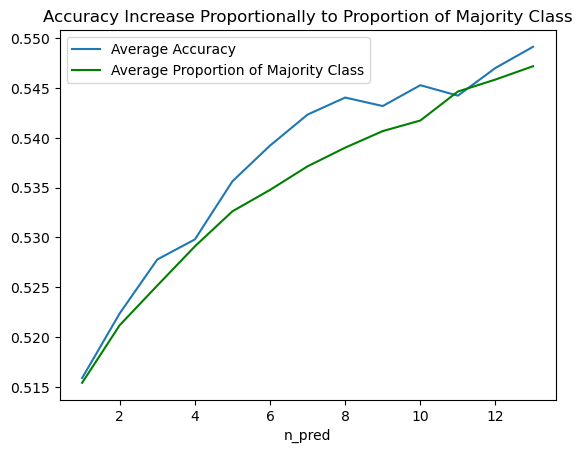

Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: [[1.         0.98548749]
 [0.98548749 1.        ]]


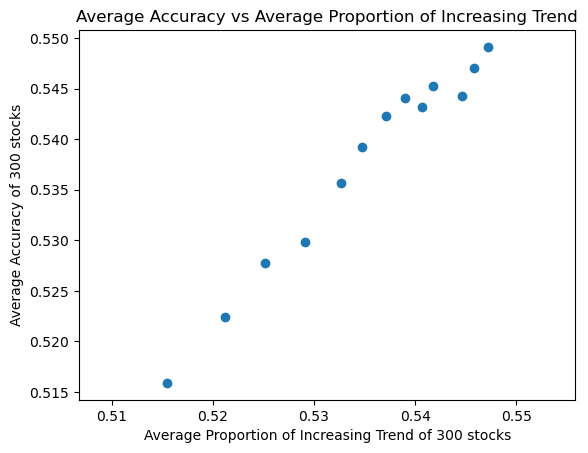

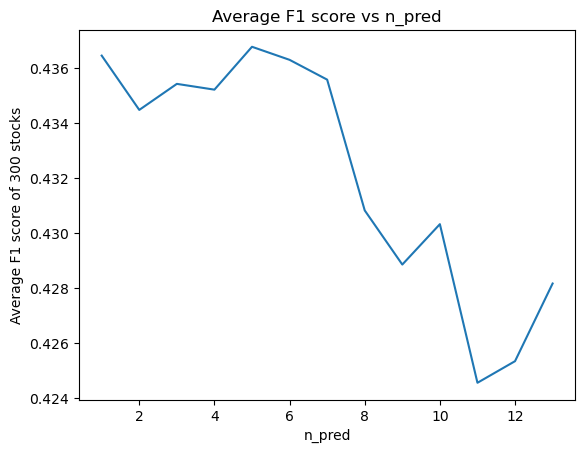

In [15]:
# To visualize how the accuracy, proportion of a Increasing trend and F1 scores of the model changes over time
# Graph 1: Accuracy increases as the n_pred increases

plt.plot(range(1, len(accuracies_1) + 1), accuracies_1, label = "Average Accuracy")
plt.plot(range(1, len(prop_1s_1) + 1), prop_1s_1, label = "Average Proportion of Majority Class", color = "green")

plt.xlabel("n_pred")
plt.title("Accuracy Increase Proportionally to Proportion of Majority Class")
plt.legend()
plt.show()



# Graph 3: Accuracy is correlated to proportion of Increasing trend
plt.scatter(prop_1s_1 , accuracies_1)
plt.ylabel("Average Accuracy of 300 stocks")
plt.xlabel("Average Proportion of Increasing Trend of 300 stocks")
plt.title("Average Accuracy vs Average Proportion of Increasing Trend")
print(f"Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: {np.corrcoef(accuracies_1, prop_1s_1 )}")
plt.axis("equal")
plt.show()

# Graph 4: F1 Score decreases as n_pred increases, indicating the model perform worse as n_pred increases
plt.plot(range(1, len(F1_scores_1) + 1), F1_scores_1)
plt.xlabel("n_pred")
plt.ylabel("Average F1 score of 300 stocks")
plt.title("Average F1 score vs n_pred")
plt.show()

In [87]:
# Working on a larger value of the n_pred and it verified the idea above that as the proportion of the positive trend increases as the number of days used for prediction increase, hence increasing the accuracy
prop_1s = []
accuracies = []
F1_scores = []
for i in range(14,50,7):
    n_pred = i
    counter = 1
    last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
    features = {'Last RSI':last_rsi}
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    alt = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 100:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        try:
            single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
            H0["Accuracy"].append(single_accuracy)
            H0["Confusion Matrix"].append(single_cm)
            H0["F1 Score"].append(single_f1)
        except Exception as e: 
            print(f"{file} can't be use for training for n_pred = {i} as its train class consists of only one class")
            print(f"Erorr: {str(e)}")
        counter += 1
    print(f"----------------------------------------n_pred = {i}-----------------------------------------")
    prop_1, accuracy, f1_score = res_summary(H0)
    prop_1s.append(prop_1)
    accuracies.append(accuracy)
    F1_scores.append(f1_score)

print(prop_1s)

KeyboardInterrupt: 

In [ ]:
# It seems like the prediction accuracy is just increase while the number of prediction days increase. It's unlikely that this is due to RSI is better at predicting longer trends. The main reason behind this is that most class going up in the long run, so the model just 
# predict most class as going up will result in higher accuracy, this can be told the constant / decreasing F1 score while the accuracy is increasing. 

## To verify this idea, we test the same model again with one exception: We use the smote techniques to make the output to be balanced:
prop_1s_3  = []
accuracies_3 = []
f1_scores_3 = []
sm = SMOTE(random_state=42)
for i in range(1,14):
    n_pred = i
    counter = 1
    last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
    features = {'Last RSI':last_rsi}
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    alt = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 300:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
        H0["Accuracy"].append(single_accuracy)
        H0["Confusion Matrix"].append(single_cm)
        H0["F1 Score"].append(single_f1)
        counter += 1
    print(f"----------------------------------------n_pred = {i}-----------------------------------------")
    prop_1, accuracy, f1 = res_summary(H0)
    prop_1s_3.append(prop_1)
    accuracies_3.append(accuracy)
    f1_scores_3.append(f1)

print(prop_1s_3)


----------------------------------------n_pred = 1-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5052799464000871            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ [[120.42       114.37666667]  │
│                  │  [110.85333333 109.88666667]] │
├──────────────────┼───────────────────────────────┤
│ F1 Score         │ 0.48962082861488254           │
╘══════════════════╧═══════════════════════════════╛
----------------------------------------n_pred = 2-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5088045694706259            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ 

## 2nd Insights

In [ ]:
# Make a comparison if using the SMOTE or excluding the dataset is better for prediction
# Picking n_pred = 5 as it's more meaningful to predict a one week trend as it also has a good combination of test accruacy and f1 score
n_pred = 10
volatility = lambda df: df['Returns'][:-n_pred].std()
last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
rsi_std = lambda df: df['RSI'][:-n_pred].std()
last_macd = lambda df: df["MACD Indicator"].values[- n_pred - 1]
features = {
    'Volatility': volatility,
    'Last RSI': last_rsi,
    'RSI std': rsi_std,
    'Log Mean Volume': log_mean_volume,
    'Last MACD': last_macd
}
H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
alts = [{"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]} for i in range(5)]
counter = 1
for file in glob.glob("Data/Stocks/*.txt"):
    if counter > 300:
        break        
    df = data_preprocessing(file, n_pred = n_pred)
    single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
    single_df.dropna(inplace = True)
    X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
    y = single_df[f"{n_pred}-day-Trend"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

    # Using smote techinque will processed every file  
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    sm_accuracy, sm_cm, sm_f1 = run_svm(X_train_sm, X_test, y_train_sm, y_test)
    H0["Accuracy"].append(sm_accuracy)  
    H0["Confusion Matrix"].append(sm_cm)
    H0["F1 Score"].append(sm_f1)

    # If there're some files that has much higher proportion of a particular class, then exclude those files
    label_dist = Counter(y_train)
    try:
        accuracy, cm, f1 = run_svm(X_train, X_test, y_train, y_test)
        for i in range(5):
            threshold = i / 10
            if (sum(y_train) > 0) & (label_dist[1] / len(y_train) > threshold) & (label_dist[1] / len(y_train) < 1- threshold):
                alts[i]["Accuracy"].append(accuracy)
                alts[i]["Confusion Matrix"].append(cm)
                alts[i]["F1 Score"].append(f1)
    except Exception as e:
        print(f"{file} can't be use for training for n_pred = {n_pred} as its train class consists of only one class")
        print(f"Erorr: {str(e)}")
        
    counter += 1

H0s = [H0] * 5
H0_accuracies = []
H0_f1_scores = []
H0_prop_1s = []
alt_accuracies = []
alt_prop_1s = []
alt_f1_scores = []
for i in range(5):
    threshold = i / 10
    print(f"----------------------------------------threshold = {threshold}-----------------------------------------")
    print(f"Note: There're {len(alts[i]['Accuracy'])} files used for training")
    H0_prop_1, H0_accuracy, H0_f1_score, alt_prop_1, alt_accuracy, alt_f1_score = res_summary(H0s[i], alts[i])
    
    H0_prop_1s.append(H0_prop_1)
    H0_accuracies.append(H0_accuracy)
    H0_f1_scores.append(H0_f1_score)
    alt_prop_1s.append(alt_prop_1)
    alt_accuracies.append(alt_accuracy)
    alt_f1_scores.append(alt_f1_score)
    print(f"The proportion of 1 using SMOTE techinique is {H0_prop_1}")
    print(f"The proportion of 1 using elimination techinique is {alt_prop_1}")

----------------------------------------threshold = 0.0-----------------------------------------
Note: There're 220 files used for training
╒══════════════════╤═══════════════════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │ alt                           │
╞══════════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5083081196636123            │ 0.5213095321233352            │
├──────────────────┼───────────────────────────────┼───────────────────────────────┤
│ Confusion Matrix │ [[138.84       114.37333333]  │ [[200.29090909  90.54545455]  │
│                  │  [117.32666667  96.88333333]] │  [161.56818182  70.66818182]] │
├──────────────────┼───────────────────────────────┼───────────────────────────────┤
│ F1 Score         │ 0.4810369963089109            │ 0.4675895127889946            │
╘══════════════════╧═══════════════════════════════╧═══════════════════════════════╛
The propor

In [ ]:
# Make a comparison if using the SMOTE or excluding the dataset is better for prediction
# Picking n_pred = 14 as it's more meaningful to predict a one week trend as it also has a good combination of test accruacy and f1 score
n_pred = 14
last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
features = {
    'Last RSI': last_rsi,
}
H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
alts = [{"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]} for i in range(5)]
counter = 1
for file in glob.glob("Data/Stocks/*.txt"):
    if counter > 200:
        break        
    df = data_preprocessing(file, n_pred = n_pred)
    single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
    single_df.dropna(inplace = True)
    X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
    y = single_df[f"{n_pred}-day-Trend"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)

    # Using smote techinque will processed every file  
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    sm_accuracy, sm_cm, sm_f1 = run_svm(X_train_sm, X_test, y_train_sm, y_test)
    H0["Accuracy"].append(sm_accuracy)  
    H0["Confusion Matrix"].append(sm_cm)
    H0["F1 Score"].append(sm_f1)

    # If there're some files that has much higher proportion of a particular class, then exclude those files
    label_dist = Counter(y_train)
    try:
        accuracy, cm, f1 = run_svm(X_train, X_test, y_train, y_test)
        for i in range(5):
            threshold = i / 10
            if (sum(y_train) > 0) & (label_dist[1] / len(y_train) > threshold) & (label_dist[1] / len(y_train) < 1- threshold):
                alts[i]["Accuracy"].append(accuracy)
                alts[i]["Confusion Matrix"].append(cm)
                alts[i]["F1 Score"].append(f1)
    except Exception as e:
        print(f"{file} can't be use for training for n_pred = {n_pred} as its train class consists of only one class")
        print(f"Erorr: {str(e)}")
        
    counter += 1

H0s = [H0] * 5
for i in range(5):
    threshold = i / 10
    print(f"----------------------------------------threshold = {threshold}-----------------------------------------")
    print(f"Note: There're {len(alts[i]['Accuracy'])} files used for training")
    H0_prop_1, alt_prop_1 = res_summary(H0s[i], alts[i])
    print(f"The proportion of 1 using SMOTE techinique is {H0_prop_1}")
    print(f"The proportion of 1 using elimination techinique is {alt_prop_1}")

----------------------------------------threshold = 0.0-----------------------------------------
Note: There're 152 files used for training
╒═══════════════╤════════════════╤═══════════════════════╤════════════════════════╤═══════════════╤════════════════╕
│   H0_Accuracy │   alt_Accuracy │ H0_Confusion Matrix   │ alt_Confusion Matrix   │   H0_F1 Score │   alt_F1 Score │
╞═══════════════╪════════════════╪═══════════════════════╪════════════════════════╪═══════════════╪════════════════╡
│      0.497768 │       0.532366 │ [[281 270]            │ [[361 190]             │      0.489206 │       0.494577 │
│               │                │  [180 165]]           │  [229 116]]            │               │                │
├───────────────┼────────────────┼───────────────────────┼────────────────────────┼───────────────┼────────────────┤
│      0.512081 │       0.51844  │ [[447 765]            │ [[1071  141]           │      0.503281 │       0.432279 │
│               │                │  [386 

## 3rd Insights

In [ ]:
# It seems like the prediction accuracy is just increase while the number of prediction days increase. It's unlikely that this is due to RSI is better at predicting longer trends. The main reason behind this is that most class going up in the long run, so the model just 
# predict most class as going up will result in higher accuracy, this can be told the constant / decreasing F1 score while the accuracy is increasing. 

## To verify this idea, we test the same model again with one exception: We use the smote techniques to make the output to be balanced:
prop_1s_3  = []
accuracies_3 = []
f1_scores_3 = []
sm = SMOTE(random_state=42)
for i in range(1,14):
    n_pred = i
    counter = 1
    last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
    features = {'Last RSI':last_rsi}
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    alt = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 300:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
        H0["Accuracy"].append(single_accuracy)
        H0["Confusion Matrix"].append(single_cm)
        H0["F1 Score"].append(single_f1)
        counter += 1
    print(f"----------------------------------------n_pred = {i}-----------------------------------------")
    prop_1, accuracy, f1 = res_summary(H0)
    prop_1s_3.append(prop_1)
    accuracies_3.append(accuracy)
    f1_scores_3.append(f1)

print(prop_1s_3)


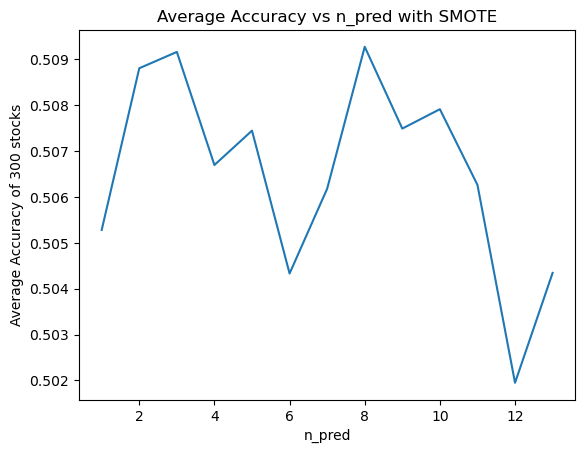

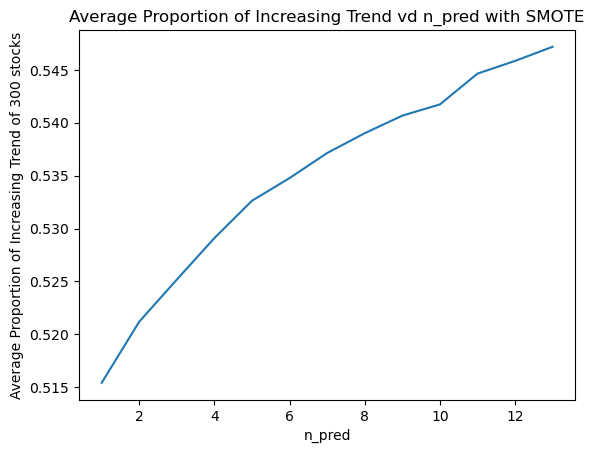

Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: [[ 1.         -0.35022821]
 [-0.35022821  1.        ]]


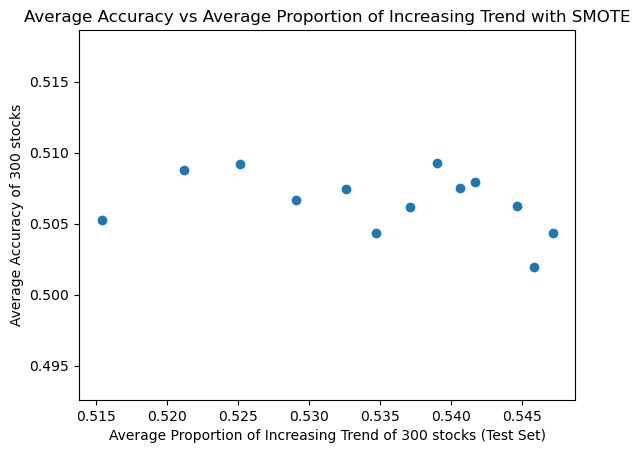

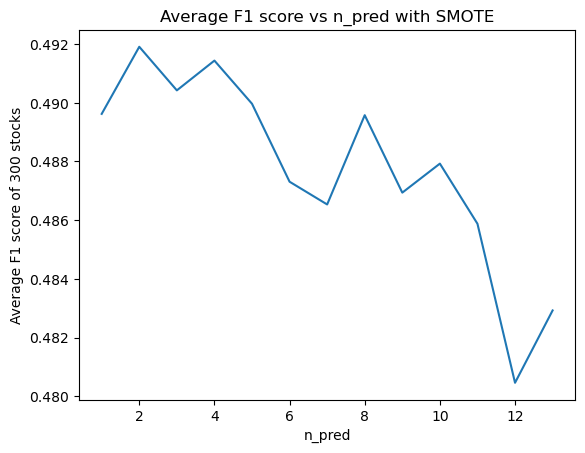

In [81]:
# To visualize how the accuracy, proportion of a Increasing trend and F1 scores of the model changes over time
# Graph 1: Accuracy increases as the n_pred increases
plt.plot(range(1, len(accuracies_3) + 1), accuracies_3)
plt.xlabel("n_pred")
plt.ylabel("Average Accuracy of 300 stocks")
plt.title("Average Accuracy vs n_pred with SMOTE")
plt.show()

# Graph 2: Proportion of Increasing Trend increases as the n_pred increases
plt.plot(range(1, len(prop_1s_3) + 1), prop_1s_3)
plt.xlabel("n_pred")
plt.ylabel("Average Proportion of Increasing Trend of 300 stocks")
plt.title("Average Proportion of Increasing Trend vd n_pred with SMOTE")
plt.show()

# Graph 3: Accuracy is correlated to proportion of Increasing trend
plt.scatter(prop_1s_3, accuracies_3)
plt.ylabel("Average Accuracy of 300 stocks")
plt.xlabel("Average Proportion of Increasing Trend of 300 stocks (Test Set)")
plt.title("Average Accuracy vs Average Proportion of Increasing Trend with SMOTE")
print(f"Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: {np.corrcoef(accuracies_3, prop_1s_3)}")
plt.axis("equal")
plt.show()

# Graph 4: F1 Score decreases as n_pred increases, indicating the model perform worse as n_pred increases
plt.plot(range(1, len(f1_scores_3) + 1), f1_scores_3)
plt.xlabel("n_pred")
plt.ylabel("Average F1 score of 300 stocks")
plt.title("Average F1 score vs n_pred with SMOTE")
plt.show()

# 4th Insights

In [ ]:
# Since RSI is more of a classification problem (< 30 is oversold / > 70 is overbought), we should try is as compared to the continuous value to made the comparison

# Interpretation: It seems like the prediction accuracy is worse than that from using the RSI itself. It could potentially means that for each of the stocks, it's it's own threshold for which it would adapt to whereas for the < 30 and >70, it's more of a general thumb of rule
# prop_1s_5  = []
# accuracies_5 = []
# f1_scores_5 = []
sm = SMOTE(random_state=42)
for i in range(1,14):
    n_pred = i
    counter = 1
    overbought = lambda df: 1 if df['RSI'].values[-n_pred - 1] > 70 else 0
    oversold = lambda df: 1 if df['RSI'].values[-n_pred - 1] < 30 else 0
    features = {
        'Overbought':overbought,
        'Oversold':oversold
        }
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    alt = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 300:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = 14 + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        break
        X_train, y_train = sm.fit_resample(X_train, y_train)
        single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
        H0["Accuracy"].append(single_accuracy)
        H0["Confusion Matrix"].append(single_cm)
        H0["F1 Score"].append(single_f1)
        counter += 1
    print(f"----------------------------------------n_pred = {i}-----------------------------------------")
    prop_1_5, accuracy_5, f1_score_5 = res_summary(H0)
    prop_1s_5.append(prop_1_5)
    accuracies_5.append(accuracy_5)
    f1_scores_5.append(f1_score_5)
    prop_1s.append(prop_1)

print(prop_1s)

----------------------------------------n_pred = 1-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.505065071787419             │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ [[128.77333333 106.03      ]  │
│                  │  [120.09       100.65      ]] │
├──────────────────┼───────────────────────────────┤
│ F1 Score         │ 0.4328995335569087            │
╘══════════════════╧═══════════════════════════════╛
----------------------------------------n_pred = 2-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5099620210366136            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ 

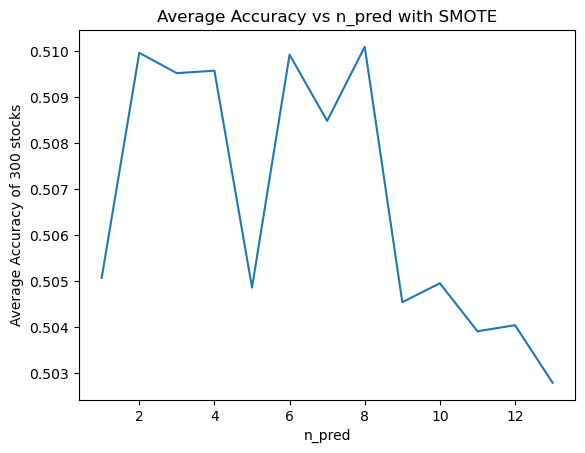

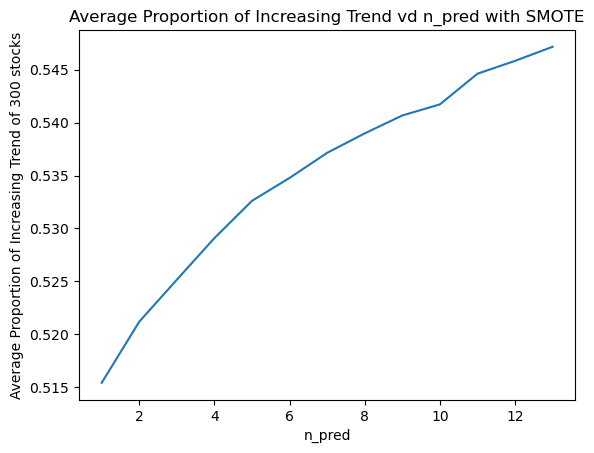

Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: [[ 1.         -0.49054865]
 [-0.49054865  1.        ]]


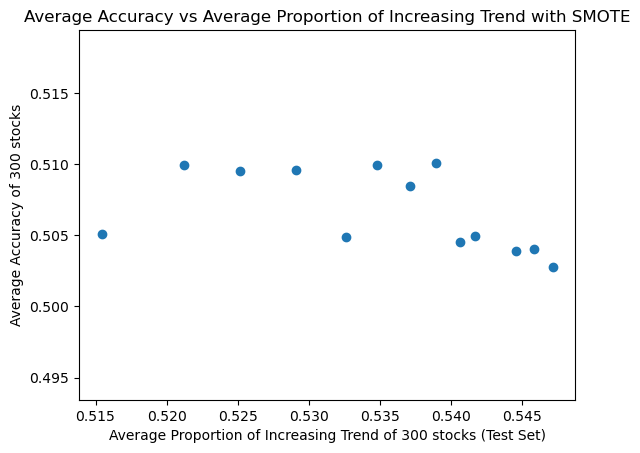

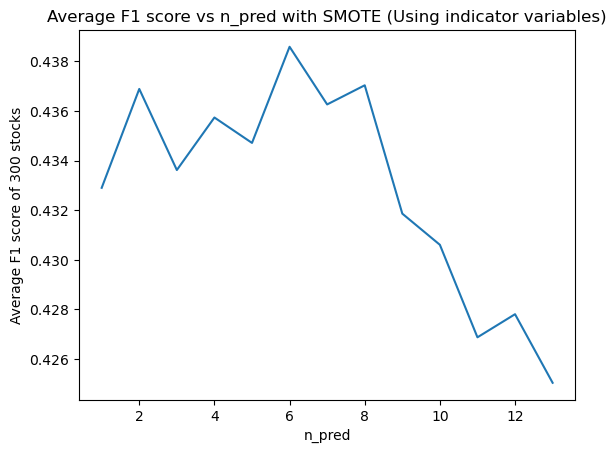

In [82]:
# To visualize how the accuracy, proportion of a Increasing trend and F1 scores of the model changes over time
# Graph 1: Accuracy increases as the n_pred increases
plt.plot(range(1, len(accuracies_5) + 1), accuracies_5)
plt.xlabel("n_pred")
plt.ylabel("Average Accuracy of 300 stocks")
plt.title("Average Accuracy vs n_pred with SMOTE")
plt.show()

# Graph 2: Proportion of Increasing Trend increases as the n_pred increases
plt.plot(range(1, len(prop_1s_5) + 1), prop_1s_5)
plt.xlabel("n_pred")
plt.ylabel("Average Proportion of Increasing Trend of 300 stocks")
plt.title("Average Proportion of Increasing Trend vd n_pred with SMOTE")
plt.show()

# Graph 3: Accuracy is correlated to proportion of Increasing trend
plt.scatter(prop_1s_5, accuracies_5)
plt.ylabel("Average Accuracy of 300 stocks")
plt.xlabel("Average Proportion of Increasing Trend of 300 stocks (Test Set)")
plt.title("Average Accuracy vs Average Proportion of Increasing Trend with SMOTE")
print(f"Correlation between the Accuracy and the Proportion of Increasing Trend over n_pred from 1 - 13 is: {np.corrcoef(accuracies_5, prop_1s_5)}")
plt.axis("equal")
plt.show()

# Graph 4: F1 Score decreases as n_pred increases, indicating the model perform worse as n_pred increases
plt.plot(range(1, len(f1_scores_5) + 1), f1_scores_5)
plt.xlabel("n_pred")
plt.ylabel("Average F1 score of 300 stocks")
plt.title("Average F1 score vs n_pred with SMOTE (Using indicator variables)")
plt.show()

# Caveats

In [ ]:
# See how bollinger bands helps with increasing the accuracy:

prop_1s  = []
n_pred = 2
sm = SMOTE(random_state=42)
volatility = lambda df: df['Returns'][:-n_pred].std()
last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
rsi_std = lambda df: df['RSI'][:-n_pred].std()
last_macd = lambda df: df["MACD Indicator"].values[- n_pred - 1]
bollinger_overbought = lambda df: 1 if df["SMA_20"].values[-n_pred - 1] > df["Bollinger_Upper"].values[-n_pred - 1] else 0
bollinger_oversold = lambda df: 1 if df["SMA_20"].values[-n_pred - 1] < df["Bollinger_Lower"].values[-n_pred - 1] else 0
features = {
    'Volatility': volatility,
    'Last RSI': last_rsi,
    'RSI std': rsi_std,
    'Log Mean Volume': log_mean_volume,
    'Last MACD': last_macd,
    'Overbought' : bollinger_overbought,
    'Oversold' : bollinger_oversold
}
for i in range(1,8):
    n_days = i
    counter = 1
    H0 = {"Accuracy":[], "Confusion Matrix":[], "F1 Score":[]}
    for file in glob.glob("Data/Stocks/*.txt"):
        if counter > 300:
            break        
        df = data_preprocessing(file, n_pred = n_pred)
        single_df = single_asset_summarization(df, features = features, stride = 1, n_days = n_days + n_pred, n_pred = n_pred)
        single_df.dropna(inplace = True)
        X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
        y = single_df[f"{n_pred}-day-Trend"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        single_accuracy, single_cm, single_f1 = run_svm(X_train, X_test, y_train, y_test)
        H0["Accuracy"].append(single_accuracy)
        H0["Confusion Matrix"].append(single_cm)
        H0["F1 Score"].append(single_f1)
        counter += 1
    print(f"----------------------------------------n_days = {i}-----------------------------------------")
    prop_1 = res_summary(H0)
    prop_1s.append(prop_1)

print(prop_1s)

----------------------------------------n_days = 1-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5066690860929721            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ [[129.93       107.75333333]  │
│                  │  [117.41333333  99.41      ]] │
├──────────────────┼───────────────────────────────┤
│ F1 Score         │ 0.4905353042358513            │
╘══════════════════╧═══════════════════════════════╛
----------------------------------------n_days = 2-----------------------------------------
╒══════════════════╤═══════════════════════════════╕
│ Eval Metrics     │ H0                            │
╞══════════════════╪═══════════════════════════════╡
│ Accuracy         │ 0.5056323094430145            │
├──────────────────┼───────────────────────────────┤
│ Confusion Matrix │ 

In [110]:
volatility = lambda df: df['Returns'][:-n_pred].std()
last_rsi = lambda df: df['RSI'].values[-n_pred - 1]
rsi_std = lambda df: df['RSI'][:-n_pred].std()
last_macd = lambda df: df["MACD Indicator"].values[- n_pred - 1]
bollinger_overbought = lambda df: 1 if df["SMA_20"].values[-n_pred - 1] > df["Bollinger_Upper"].values[-n_pred - 1] else 0
bollinger_oversold = lambda df: 1 if df["SMA_20"].values[-n_pred - 1] < df["Bollinger_Lower"].values[-n_pred - 1] else 0
features = {
    'Volatility': volatility,
    'Last RSI': last_rsi,
    'RSI std': rsi_std,
    'Log Mean Volume': log_mean_volume,
    'Last MACD': last_macd,
    'Overbought' : bollinger_overbought,
    'Oversold' : bollinger_oversold
}
for file in glob.glob("Data/Stocks/*.txt"):
    df = data_preprocessing(file, n_pred = n_pred)
    single_df = single_asset_summarization(df, features = features, stride = 1, n_days = n_days + n_pred, n_pred = n_pred)
    single_df.dropna(inplace = True)
    X = single_df.drop([f"{n_pred}-day-Trend"], axis = 1)
    y = single_df[f"{n_pred}-day-Trend"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = False)
    break


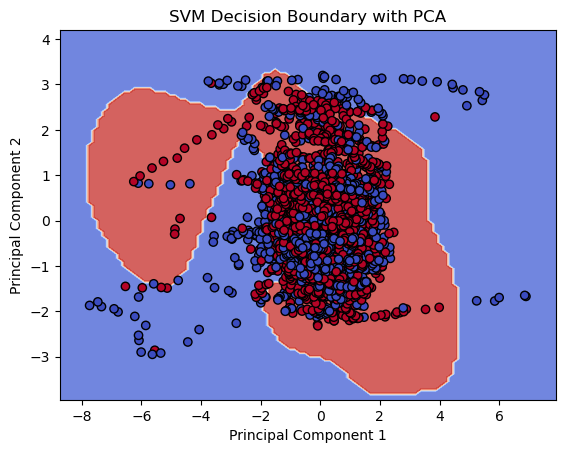

In [112]:
from sklearn.decomposition import PCA
X_scaled = StandardScaler().fit_transform(X_train)
# Reduce data to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train SVM on reduced data
svm.fit(X_pca, y_train)

# Create grid for decision boundary
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 100),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = svm.predict(grid).reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("SVM Decision Boundary with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


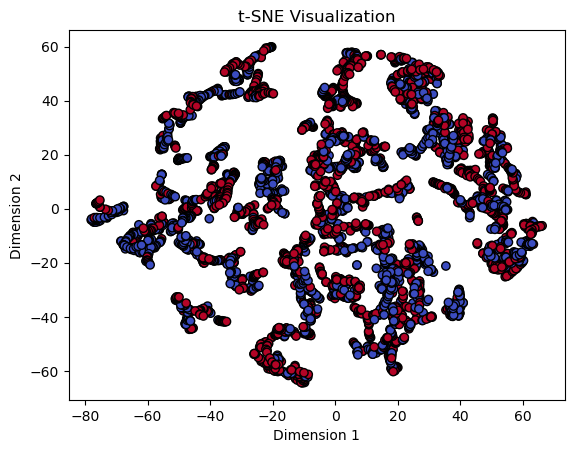

In [120]:
from sklearn.manifold import TSNE

# t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize the transformed data
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train , cmap='coolwarm', edgecolor='k')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
